In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt, gc, os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/amexfeather/test_data_f32.ftr
/kaggle/input/amexfeather/train_data.ftr
/kaggle/input/amexfeather/train_data_f32.ftr
/kaggle/input/amexfeather/test_data.ftr
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import os
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pandas as pd
import warnings
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay, accuracy_score
import shap
import itertools

In [11]:
train = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet").groupby('customer_ID').tail(4)
test = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet").groupby('customer_ID').tail(4)
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,0.006073,...,-1,-1,-1,0,0,0.0,NaN,0,0.004753,0
10,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-01-11,0.909811,0,0.002829,1.004798,0.008175,0.098882,0.0,0.003238,...,-1,-1,-1,0,0,0.0,NaN,0,0.003004,0
11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,...,-1,-1,-1,0,0,0.0,NaN,0,0.006346,0
12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,...,-1,-1,-1,0,0,0.0,NaN,0,0.002970,0
22,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-12-29,0.861109,10,0.006711,0.819772,0.007966,0.139138,0.0,0.005235,...,-1,-1,-1,0,0,0.0,NaN,0,0.003133,0


In [12]:
#shapes
train.shape, test.shape, train_labels.shape

((1802318, 190), (3656852, 190), (458913, 2))

In [13]:
#Checking Missing values having more than 40%
columns = train.columns[(train.isna().sum()/len(train))*100>40]

In [14]:
#Drop the missing columns having more than 40%
train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)

In [15]:
#fill the missing values
train = train.bfill(axis='rows').ffill(axis='rows')
test = test.bfill(axis='rows').ffill(axis='rows')

In [16]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [17]:
train =train.groupby('customer_ID').tail(1)
test = test.groupby('customer_ID').tail(1)

In [18]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [19]:
#shape
train.shape, train_labels.shape, test.shape

((458913, 173), (458913, 2), (924621, 173))

In [20]:
#Type Conversion
obj_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for col in obj_col:
    train[col]=train[col].astype('int').astype('str')
    test[col]=test[col].astype('int').astype('str')
    print(train[col].unique())
    print(test[col].unique())

['0' '1' '2' '-1']
['0' '1' '2' '-1']
['2' '1' '3' '7' '5' '6' '4' '-1']
['2' '3' '6' '1' '7' '5' '4' '-1']
['1' '0' '-1']
['0' '1' '-1']
['0' '-1' '1']
['0' '-1' '1']
['5' '0' '7' '2' '3' '6' '4' '-1']
['0' '4' '5' '3' '7' '6' '-1' '2']
['0' '1' '-1']
['1' '0' '-1']
['2' '1']
['1' '2']
['0' '3' '4' '5' '1' '2']
['0' '3' '4' '2' '1' '5']
['0' '2' '3' '-1']
['3' '0' '2' '-1']
['-1' '1']
['-1' '1']
['6' '3' '5' '4' '2' '1' '-1']
['6' '4' '5' '2' '1' '3' '-1']


**Data Preparation**

In [21]:
train = train.merge(train_labels, how='inner', on="customer_ID")

In [22]:
train.head()

,index,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target
0,12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,...,-1,-1,-1,0,0,0.0,0,0.002970,0,0
1,25,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,...,-1,-1,-1,0,0,0.0,0,0.003169,0,0
2,38,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880875,0,0.004284,0.812649,0.006450,0.369885,0.0,...,-1,-1,-1,0,0,0.0,0,0.000834,0,0
3,51,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,...,-1,-1,-1,0,0,0.0,0,0.005560,0,0
4,64,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.871900,0,0.007679,0.815746,0.001247,0.463104,0.0,...,-1,-1,-1,0,0,0.0,0,0.006944,0,0


In [23]:
test_data = test.copy()
train = train.drop(['index','customer_ID', 'S_2'], axis=1)
test = test.drop(['index','customer_ID', 'S_2'], axis=1)

In [24]:
#one hot Encoding for categorical features
obj_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
train = pd.get_dummies(train, columns=obj_col, drop_first=True)
test = pd.get_dummies(test, columns=obj_col, drop_first=True)
train.shape, test.shape

((458913, 199), (924621, 198))

In [25]:
Features=train.loc[:, test.columns]
target = train['target']

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

**Model Building and Evaluation**

In [ ]:
# XGB = XGBClassifier(n_estimators=10, max_depth=6, learning_rate=0.1)#.fit(Features, target)

# knn = KNeighborsClassifier(n_neighbors=3)

# svm = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

In [ ]:
# np.mean(cross_val_score(XGB, Features, target, scoring='accuracy', cv=5))

# np.mean(cross_val_score(knn, Features, target, scoring='accuracy', cv=5))

# np.mean(cross_val_score(svm, Features, target, scoring='accuracy', cv=5))

In [28]:
# XGB = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1).fit(Features, target)

# knn = KNeighborsClassifier(n_neighbors=3).fit(Features, target)

svm = SGDClassifier(loss="hinge", penalty="l2").fit(Features, target)

In [29]:
# y_pred = XGB.predict(Features)
# y_pred = knn.predict(Features)
y_pred = svm.predict(Features)

accuracy_score(target, y_pred)

0.8247968569205928

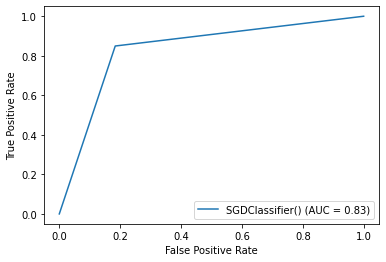

In [30]:
#AUC (ROC curve)
fpr, tpr, thresholds = roc_curve(target, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=svm)
display.plot()
plt.show()

In [31]:
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87    340085
           1       0.62      0.85      0.72    118828

    accuracy                           0.82    458913
   macro avg       0.78      0.83      0.79    458913
weighted avg       0.86      0.82      0.83    458913



**Submission to Kaggle**

In [32]:
# test_data['prediction']=XGB.predict_proba(test)[:,1]
# test_data['prediction']=knn.predict_proba(test)[:,1]
test_data['prediction']=svm.predict(test)

test_data[['customer_ID','prediction']].to_csv("submission.csv", index=False)